# Fit harmonics to filtered $A_n$ data

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from soda.dataio.conversion import readotps

from scipy.optimize import fmin_powell, fmin, fmin_cg, fmin_ncg

from theano import shared
from theano import tensor as tt

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from mycurrents import oceanmooring as om
from soda.utils.harmonic_analysis import harmonic_fit_array

from tqdm import tqdm

import matplotlib as mpl

In [2]:
%matplotlib notebook

In [3]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'large'

In [4]:
#ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_wout_motion.nc'
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')
ds1

<xarray.Dataset>
Dimensions:   (freqs: 3, modes: 4, time: 264601, timeslow: 728, z: 100)
Coordinates:
  * modes     (modes) int64 0 1 2 3
  * time      (time) datetime64[ns] 2016-04-30 ... 2016-10-30T18:00:00
  * z         (z) float64 0.0 -2.525 -5.051 -7.576 ... -244.9 -247.5 -250.0
  * timeslow  (timeslow) datetime64[ns] 2016-05-01 ... 2016-10-29T18:00:00
  * freqs     (freqs) float64 0.0001405 0.000281 0.0004216
Data variables:
    Atide     (time, modes) float64 ...
    phi       (timeslow, modes, z) float64 ...
    rhofit    (time, z) float64 ...
    r10       (timeslow, modes) float64 ...
    rhobar    (timeslow, z) float64 ...
    amp       (timeslow, modes, freqs) float64 ...
    phs       (timeslow, modes, freqs) float64 ...
    A_n       (time, modes) float64 ...
    N2        (timeslow, z) float64 ...
    cn        (timeslow, modes) float64 ...
Attributes:
    Y:            -13.75895
    ncfile:       /home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Gridd...
    group: 

In [46]:
# Filter each time series and concatenate
A1 = om.OceanMooring(ds1.time.values, ds1['A_n'][:,0],0.0)
A2 = om.OceanMooring(ds2.time.values, ds2['A_n'][:,0],0.0)

A1f = om.OceanMooring(A1.t, A1.filt((34*3600, 3*3600), btype='band'), 0.0)
A2f = om.OceanMooring(A2.t, A2.filt((34*3600, 3*3600), btype='band'), 0.0)

A_n = A1f.concat(A2f)
A_n_1h = xr.DataArray(A_n.y[::60], dims=('time'), coords={'time':A_n.t[::60]})


# A_n_1h.loc['2016-09-15':'2016-10-31']=np.nan

#A_n_1h = A_n_1h.sel(time=slice('2016-11-02','2017-05-02'))

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


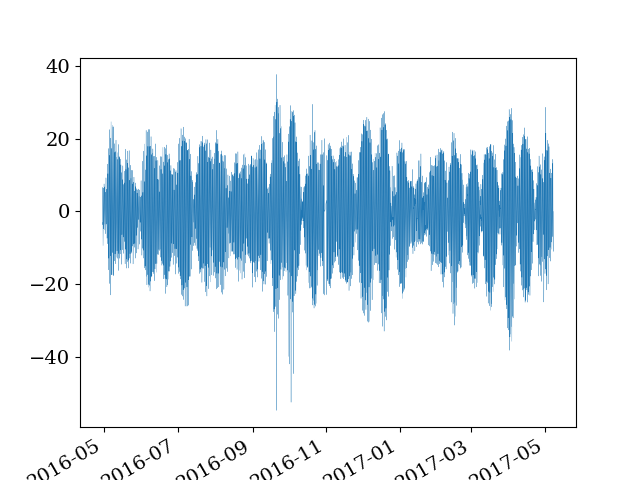

In [47]:
plt.figure()
A_n_1h.plot(lw=0.2)

In [24]:
def sine_model(beta_s, ff, t):
    n = len(ff)

    result = beta_s[0]*np.ones_like(t)
    for ii in range(0,n):
        result += beta_s[2*ii+1]*np.cos(ff[ii] * t) + beta_s[2*ii+2]*np.sin(ff[ii]*t)

    return result

def sine_model_pm(beta_s, ff, t):
    n = len(ff)

    result = beta_s[0] + beta_s[1]*t
    for ii in range(0,n):
        result += beta_s[2*ii+2]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+3]*pm.math.sin(ff[ii]*t)

    return result

def sine_model_notrend_pm(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0]+0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+2]*pm.math.sin(ff[ii]*t)

    return result
    
def cosine_model_pm(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0]+0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*pm.math.cos(ff[ii] * t - beta_s[2*ii+2])

    return result

def sine_model_notrend(beta_s, ff, t):
    n = len(ff)
    
    result = beta_s[0] + 0*t
    for ii in range(0,n):
        result += beta_s[2*ii+1]*np.cos(ff[ii] * t) + beta_s[2*ii+2]*np.sin(ff[ii]*t)

    return result    

def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    #result = np.zeros(t.shape)
    result = beta_s[0] + 0*t

    for ii in range(0,n):
        result += beta_s[2*ii+1]*np.cos(ff[ii] * t) + beta_s[2*ii+2]*np.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = np.zeros(t.shape) # Imaginary mean component is zero

    for ii in range(0,n):
        result_i += beta_s[2*ii+1]*np.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+2]*np.sin(ff[ii]*t + np.pi/2)
    
    return np.sqrt(result*result + result_i*result_i)

# def sine_model_envelope_pm(beta_s, ff, t):
#     n = len(ff)
    
#     #result = t*0
    
#     result = tt.zeros(t.shape)

#     for ii in range(0,n):
#         result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
#     # Compute the imaginary part by adding a 90 degree phase shift
#     #result_i = t*0
#     result_i = tt.zeros(t.shape)

#     for ii in range(0,n):
#         result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
#             + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
#     return pm.math.sqrt(result*result + result_i*result_i)

In [48]:
# Create a function with similar functionality as harmonic_fit in soda
def harmonic_fit_mcmc(time, X, frq, mask=None, axis=0, basetime=None,         **kwargs):
    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    # Convert the time to days
    dtime = SecondsSince(time, basetime=basetime )
    
    
    # Generate initvalues from least-squares fitting
    ts = timeseries(time, X)
    amp, phs, _, _, _, err = ts.tidefit(frqnames=names)
    
    initvals = {'beta_mean':0.}
    initvals = {'sigma':1.}

    ii=-1
    for aa, pp in zip(amp,phs):
        ii+=1
        initvals.update({'beta_amp_%d'%ii:aa})
        initvals.update({'beta_phs_%d'%ii:pp})
    print(initvals)

    
    dtime /= tday
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    #omega = frq
    
    # Number of parameters
    n_params = 2*len(omega) + 1
    
    print('Number of Parametrs: %d\n'%n_params, omega)

    with pm.Model() as my_model:
        ###
        # Create priors for each of our variables
        BoundNormal = pm.Bound(pm.Normal, lower=0.0)

        # Mean
        beta_mean = pm.Normal('beta_mean', mu=0, sd=1)
        # Trend
        #beta_linear = pm.Normal('beta_linear', mu=0, sd=1.)

        #beta_s = [beta_mean, beta_linear]
        beta_s=[beta_mean]

        # Harmonics
        for n in range(0,2*len(omega),2):
            beta_s.append(pm.Normal('beta_%d_re'%(n//2), mu=1., sd = 5.))
            beta_s.append(pm.Normal('beta_%d_im'%(n//2), mu=1., sd = 5.))
        #for n in range(0,len(omega)):
        #    beta_s.append(BoundNormal('beta_amp_%d'%n,mu=1., sd=10.))
        #    #beta_s.append(pm.Uniform('beta_amp_%d'%n,lower=0, upper=30))
        #    beta_s.append(pm.Uniform('beta_phs_%d'%n, lower=-np.pi, upper=np.pi))

        ###
        # Generate the likelihood function using the deterministic variable as the mean
        #mu_x = cosine_model_pm(beta_s, omega, dtime)
        #mu_x = pm.Deterministic('mu_x', cosine_model_pm(beta_s, omega, dtime))
        mu_x = sine_model_notrend_pm(beta_s, omega, dtime)

        
        #sigma = BoundNormal('sigma', mu=1.,sd=0.25)
        sigma = pm.HalfNormal('sigma',5.)
        
        #sigma = 1.0
        X_obs = pm.Normal('X_obs', mu=mu_x, sd=sigma, observed=X)
        #X_obs = pm.Normal('X_obs', mu=mu_x, sd=1, observed=X)
        
        mp = pm.find_MAP()
        print(mp)
        # Inference step...
        #step = pm.Metropolis()
        #step = pm.NUTS()
        step = None
        start = None
        trace = pm.sample(500, tune=1000, start = start, step=step, cores=2,
                         )#nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))
    
    
    # Return the trace and the parameter stats
    return trace,  my_model, omega, dtime

In [63]:
# tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1','MA2','MB2']
# tidecons = ['M2','S2','N2']
tidecons = ['M2','S2',]


frq,names = getTideFreq(tidecons)

# Add on long-term modulations
tdaysec = 86400
fA = 2*np.pi/(365*tdaysec)
fSA = 2*np.pi/(182*tdaysec)
fTA = 2*np.pi/(120*tdaysec)
# longperiods = [0, fA, fSA, fTA]
#longperiods = [0, 2*np.pi/(365*tdaysec), 2*np.pi/(182*tdaysec), 2*np.pi/(120*tdaysec)]
# longperiods = [0, 2*np.pi/(182*tdaysec),]
#longperiods = [0,  2*np.pi/(120*tdaysec), 2*np.pi/(30*tdaysec)]
# longperiods = [-fTA, -fSA, -fA, 0, fA, fSA, fTA]
# longperiods = [0, fA, fSA]
longperiods = [-fSA, -fA, 0, fA, fSA]

outputh5 = '../inputs/a0_samples_harmonicfit_M2S2lowfreq_12month.h5'
# outputh5 = '../inputs/a0_samples_harmonicfit_M2S2N2lowfreq_12month.h5'



frq_lt = []
for ff in frq:
    for ll in longperiods:
        frq_lt.append(ff+ll)

# outputh5 = '../inputs/a0_samples_harmonicfit_12month.h5'
# tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']
# # tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1','MA2','MB2']

# frq_lt,names = getTideFreq(tidecons)

basetime = datetime(2016,1,1)

# X_sd = A_n_1h.y.std()
# X_mu = A_n_1h.y.mean()

X_sd = 1
X_mu = 0

idx = ~np.isnan(A_n_1h.values)
X = A_n_1h.values[idx] - X_mu
X /= X_sd
trace, my_model, omega, dtime = harmonic_fit_mcmc(A_n_1h.time.values[idx], X, frq_lt, basetime=basetime)
pm.summary(trace)

{'sigma': 1.0, 'beta_amp_0': 11.207258557505659, 'beta_phs_0': -1.3655321175265758, 'beta_amp_1': 5.216497967616623, 'beta_phs_1': 0.3210615521610156}
Number of Parametrs: 21
 [12.106310180553516, 12.123618970425769, 12.14083317674681, 12.15804738306785, 12.175356172940102, 12.531847618165878, 12.549156408038133, 12.566370614359172, 12.583584820680212, 12.600893610552466]


logp = -29,241, ||grad|| = 0.89844: 100%|██████████| 27/27 [00:00<00:00, 158.50it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


{'beta_mean': array(-0.00684237), 'beta_0_re': array(2.53624318), 'beta_0_im': array(-0.52392229), 'beta_1_re': array(1.18445595), 'beta_1_im': array(-1.22183345), 'beta_2_re': array(2.54504898), 'beta_2_im': array(10.92602381), 'beta_3_re': array(1.92203738), 'beta_3_im': array(0.13788774), 'beta_4_re': array(2.69385289), 'beta_4_im': array(-0.46445226), 'beta_5_re': array(0.05897765), 'beta_5_im': array(-1.11501205), 'beta_6_re': array(0.74640427), 'beta_6_im': array(-0.42640371), 'beta_7_re': array(4.91667864), 'beta_7_im': array(1.66624159), 'beta_8_re': array(0.81908228), 'beta_8_im': array(1.388401), 'beta_9_re': array(-0.31891376), 'beta_9_im': array(-2.23555137), 'sigma_log__': array(1.85378283), 'sigma': array(6.38392321)}


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_9_im, beta_9_re, beta_8_im, beta_8_re, beta_7_im, beta_7_re, beta_6_im, beta_6_re, beta_5_im, beta_5_re, beta_4_im, beta_4_re, beta_3_im, beta_3_re, beta_2_im, beta_2_re, beta_1_im, beta_1_re, beta_0_im, beta_0_re, beta_mean]
Sampling 2 chains: 100%|██████████| 3000/3000 [02:09<00:00, 28.14draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_mean,-0.006591,0.067758,0.001329,-0.132302,0.130041,2708.191535,0.999052
beta_0_re,2.536422,0.102924,0.001785,2.345675,2.734696,3458.736793,0.999015
beta_0_im,-0.521816,0.093159,0.001793,-0.692342,-0.343460,2052.730136,0.999226
beta_1_re,1.184412,0.090535,0.001662,0.981004,1.346675,2613.952236,0.999230
beta_1_im,-1.225024,0.093480,0.001742,-1.436548,-1.061322,3374.798192,0.999084
beta_2_re,2.546959,0.099149,0.001923,2.337199,2.731791,3227.278208,0.999140
beta_2_im,10.926050,0.089247,0.001923,10.744038,11.098357,2789.647172,0.999014
beta_3_re,1.920132,0.091457,0.001899,1.742805,2.106983,2698.107918,0.999195
beta_3_im,0.138403,0.099622,0.001866,-0.053096,0.323913,2559.731048,1.000038
beta_4_re,2.692550,0.090843,0.001839,2.524004,2.857791,3170.473811,1.000174


In [69]:
# Get prediction time from the density file
densityh5file = '../../run_ddcurves/DATA_SHELL/ShellCrux_Uniltered_Density_BHM_VI_20162017.h5'

with h5py.File(densityh5file,'r') as f:
    rhotime = f['data/time'][:].astype('<M8[ns]')
rhotime.shape

(374,)

In [77]:
#tnew = A_n_1h.time.values[idx]
tnew = rhotime
tsecnew = SecondsSince(tnew,basetime=basetime)
tdaynew = tsecnew/86400.
nt = tnew.shape[0]

# Extract the amplitude envelope from the trace
nsamples = len(trace)
a0_pred = np.zeros((nsamples,nt))
for nn in tqdm(range(nsamples)):
    mytrace = trace[nn]
    betas =[mytrace['beta_mean']]
    for ii in range(len(omega)):
        betas.append(mytrace['beta_{}_re'.format(ii)])
        betas.append(mytrace['beta_{}_im'.format(ii)])

    env = sine_model_envelope(betas, omega, tdaynew)
    # Add the noise on
    env += np.random.normal(scale=mytrace['sigma']*0.5,size=(nt,))
    a0_pred[nn,:] = env

# plt.figure()    
# plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
# plt.fill_between(tnew, np.percentile(a0_pred,0.5,axis=0),\
#                  np.percentile(a0_pred,99.5,axis=0),color='b',alpha=0.5)
# plt.fill_between(tnew, np.min(a0_pred,axis=0),\
#                  np.max(a0_pred,axis=0),color='b',alpha=0.3)



100%|██████████| 500/500 [00:00<00:00, 1367.96it/s]


<IPython.core.display.Javascript object>


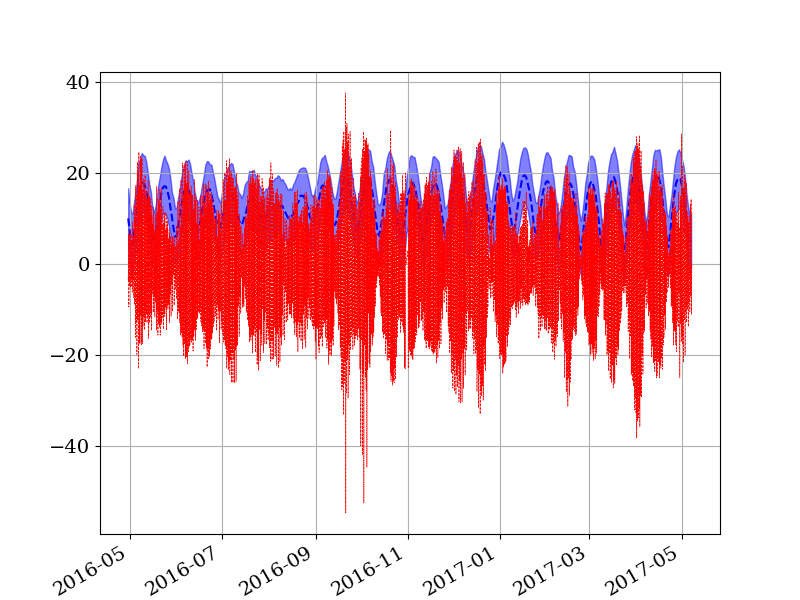

In [78]:
plt.figure(figsize=(8,6))

plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
plt.fill_between(tnew, np.percentile(a0_pred,2.5,axis=0),\
                 np.percentile(a0_pred,97.5,axis=0),color='b',alpha=0.5)

A_n_1h.plot(color='r',ls='--',lw=0.5)
# plt.fill_between(tnew, np.min(a0_pred,axis=0),\
#                  np.max(a0_pred,axis=0),color='b',alpha=0.3)
plt.grid(b=True)

In [73]:
f = h5py.File(outputh5,'w')
g = f.create_group('data')
g.create_dataset('a0-all-times-samples',data=a0_pred.T)
g.create_dataset('time',data=tdaynew)
g.create_dataset('dtime64',data=tnew.view(int))
f.close()
print(outputh5)

../inputs/a0_samples_harmonicfit_M2S2lowfreq_12month.h5


# Build a hierarchical harmonic model

 - First level is the short term (15 d) harmonic fits (M2, S2, K1 ,O1)
 - Second level is the long-term variation of those harmonics

In [73]:
def harmonic_beta(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = tt.ones_like(tdays) * aa[...,None]
    for ii in range(nomega):
        amp += Aa[ii]*pm.math.cos(omega[ii]*tdays) + Ba[ii]*pm.math.sin(omega[ii]*tdays)
    
    return amp

def harmonic_beta_time(aa, Aa, Ba, omega, tdays, timeidx):
    nomega = len(omega)
    amp = tt.ones_like(tdays[timeidx]) * aa
    for ii in range(nomega):
        amp += Aa[timeidx,ii]*pm.math.cos(omega[ii]*tdays[timeidx]) +\
            Ba[timeidx,ii]*pm.math.sin(omega[ii]*tdays[timeidx])
    
    return amp

def harmonic_fit_mcmc_bhm(time,timeidx,timelow, X, frq, frqlow, basetime=None):

    """
    Harmonic fitting using Bayesian inference
    """
    tday = 86400.
    # Convert the time to days
    dtime = SecondsSince(time, basetime=basetime )
    dtime_low = SecondsSince(timelow, basetime=basetime )

    
    dtime /= tday
    dtime_low /= tday
    
    dtime = shared(dtime)
    dtime_low = shared(dtime_low)
    timeidx = shared(timeidx)
    
    # Convert the frequencies to radians / day
    omega = [ff*tday for ff in frq]
    omega_low = [ff*tday for ff in frqlow]

    #omega = frq
    
    # Number of parameters
    nomega = len(omega) 
    nomega_low = len(omega_low)
    nt = timelow.shape[0]
    
    print(nomega, nomega_low, nt)


    with pm.Model() as rho_model:

        # Harmonic decomposition on the real and imaginary components
        aa_l_i = pm.Normal('aa_l_i', mu=0, sd=5, shape=nomega_low)
        Aa_l_i = pm.Normal('Aa_l_i', mu=0, sd=5,shape=nomega_low)
        Ba_l_i = pm.Normal('Ba_l_i', mu=0, sd=5,shape=nomega_low)
        
        aa_l_r = pm.Normal('aa_l_r', mu=0, sd=5, shape=nomega_low)
        Aa_l_r = pm.Normal('Aa_l_r', mu=0, sd=5,shape=nomega_low)
        Ba_l_r = pm.Normal('Ba_l_r', mu=0, sd=5,shape=nomega_low)
        
        # This gives the amplitude of the low-frequency amplitudes
        sigma_beta = pm.HalfNormal('sigma_beta', sd=1.0, shape=nt)
        sigma_beta_a = pm.HalfNormal('sigma_beta_a', sd=1.0, shape=(nomega,nt))
        sigma_beta_b = pm.HalfNormal('sigma_beta_b', sd=1.0, shape=(nomega,nt))
        
        
        aa = pm.Normal('aa', mu=0, sd=sigma_beta, shape=nt)
        Aa = pm.Normal('Aa',mu=harmonic_beta(aa_l_i, Aa_l_i, Ba_l_i, omega_low, dtime_low),\
                    sd=sigma_beta_a, shape=(nomega,nt))
        Ba = pm.Normal('Ba',mu=harmonic_beta(aa_l_r, Aa_l_r, Ba_l_r, omega_low, dtime_low),\
                    sd=sigma_beta_b, shape=(nomega,nt))
        
        mu_x = harmonic_beta_time(aa, Aa, Ba, omega, dtime, timeidx)

        sigma_curve = pm.HalfNormal('sigma_curve', sd=2.0 )

        y_ = pm.Normal('y', mu=mu_x, sd=sigma_curve, observed=X)
        
        ###
        # Inference step

        trace = pm.sample(500, tune=1500, step=pm.NUTS(), cores=ncores, chains=nchains)

    return trace, rho_model

In [142]:
Xsel = A_n_1h.sel(time=slice('2016-05-02','2017-05-02'))
#Xsel.loc['2016-09-15':'2016-10-15']=np.nan
idx = ~np.isnan(Xsel.values)



X = Xsel.values[idx]
tnew = Xsel.time.values[idx]

# Break the time series up into chunks
trange = pd.date_range(tnew[0],tnew[-1],freq='15D').values
tmid = trange[0:-1] + 0.5*(trange[1:]-trange[0:-1])

tindex = np.zeros(tnew.shape, np.int)
ii=0
for t1,t2 in zip(trange[0:-1], trange[1:]):
    idx = (tnew>=t1) & (tnew<=t2)
    #print(t1,t2,sum(idx))

    tindex[idx] = ii
    ii+=1


<IPython.core.display.Javascript object>


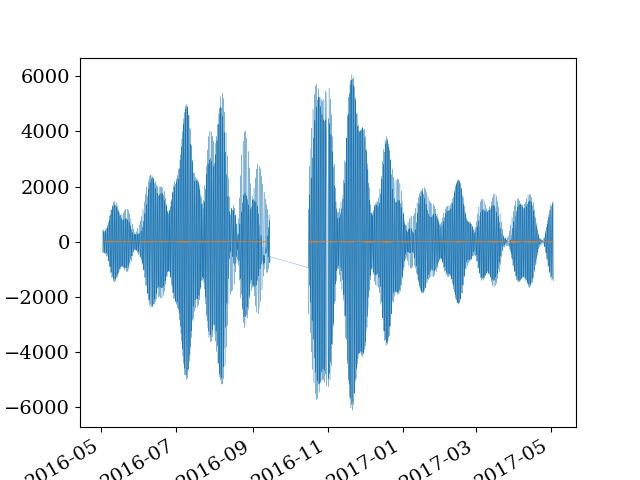

In [143]:
def harmonic_pred(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = np.ones_like(tdays) * aa
    for ii in range(nomega):
        amp += Aa[...,ii]*np.cos(omega[ii]*tdays) + Ba[...,ii]*np.sin(omega[ii]*tdays)
    
    return amp


tidecons = ['M2','S2','N2','K1','O1',]
frq,names = getTideFreq(tidecons)
#frqlow = [2*np.pi/(365*tdaysec), 2*np.pi/(180*tdaysec), 2*np.pi/(120*tdaysec)]
frqlow = [2*np.pi/(365*tdaysec), 2*np.pi/(180*tdaysec)]


# Go through and do the fitting using least-squares
nfrq = len(frq)
nfrqlow = len(frqlow)

tsec = SecondsSince(tnew)
tseclow = SecondsSince(tmid)

nt = tsec.shape[0]
ntlow = tseclow.shape[0]

# 1) Fit the tide harmonics to each 15 d block
aa = np.zeros((ntlow,))
Aa = np.zeros((ntlow, nfrq))
Ba = np.zeros((ntlow, nfrq))

for ii in range(ntlow):
    idx = tindex == ii
    Y = harmonic_fit_array(X[idx], tsec[idx], frq, axis=0)
    aa[ii] = Y[0]
    Aa[ii,:] = Y[1::2]
    Ba[ii,:] = Y[2::2]


# 2) Fit the low-frequency harmonics to these harmonics
aa_l_r = np.zeros((nfrq,))
Aa_l_r = np.zeros((nfrqlow,nfrq))
Ba_l_r = np.zeros((nfrqlow,nfrq))

aa_l_i = np.zeros((nfrq,))
Aa_l_i = np.zeros((nfrqlow,nfrq))
Ba_l_i = np.zeros((nfrqlow,nfrq))

#Y = harmonic_fit_array(aa, tseclow, frqlow, axis=0)
#aa_l_r[:] = Y[1::2]
#aa_l_i[:] = Y[2::2]

Y = harmonic_fit_array(Aa, tseclow, frqlow, axis=0)
aa_l_r[:] = Y[0,:]
Aa_l_r[:] = Y[1::2,:]
Aa_l_i[:] = Y[2::2,:]

Y = harmonic_fit_array(Ba, tseclow, frqlow, axis=0)
aa_l_i[:] = Y[0,:]
Ba_l_r[:] = Y[1::2,:]
Ba_l_i[:] = Y[2::2,:]

## Prediction
# 3) Build the tidal harmonics as a time-series
Aa_pred = np.zeros((nt,nfrq))
Ba_pred = np.zeros((nt,nfrq))

for ii in range(nfrq):
    Aa_pred[:,ii] = harmonic_pred(aa_l_r[ii], Aa_l_r[:,ii], Ba_l_r[:,ii], frqlow, tsec)
    Ba_pred[:,ii] = harmonic_pred(aa_l_i[ii], Aa_l_i[:,ii], Ba_l_i[:,ii], frqlow, tsec)


# 4) Predict the raw amplitude
a0 = harmonic_pred(0, Aa_pred, Ba_pred, frq, tsec)

plt.figure()
plt.plot(tnew,a0,lw=0.2)
Xsel.plot(lw=0.2)
#plt.plot(Ba_pred[:,1])

In [55]:
tdaysec = 86400
frqlow= [ 2*np.pi/(365*tdaysec), 2*np.pi/(182*tdaysec), 2*np.pi/(120*tdaysec)]

tidecons = ['M2','S2','N2','K1','O1',]
frq,names = getTideFreq(tidecons)

trace,  my_model = harmonic_fit_mcmc_bhm(tnew,tindex,tmid, X, frq, frqlow, basetime=basetime)
pm.summary(trace)

5 3 12


ValueError: operands could not be broadcast together with shapes (5,12) (3,12) 